Shape of dataset: (93597, 11)
   work_year experience_level employment_type           job_title  salary  \
0       2025               MI              FT  Research Scientist  208000   
1       2025               MI              FT  Research Scientist  147000   
2       2025               SE              FT  Research Scientist  173000   
3       2025               SE              FT  Research Scientist  117000   
4       2025               MI              FT         AI Engineer  100000   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             USD         208000                 US             0   
1             USD         147000                 US             0   
2             USD         173000                 US             0   
3             USD         117000                 US             0   
4             USD         100000                 US           100   

  company_location company_size  
0               US            M  
1               US      

/tmp/ipython-input-1318783157.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='R2', palette='viridis')


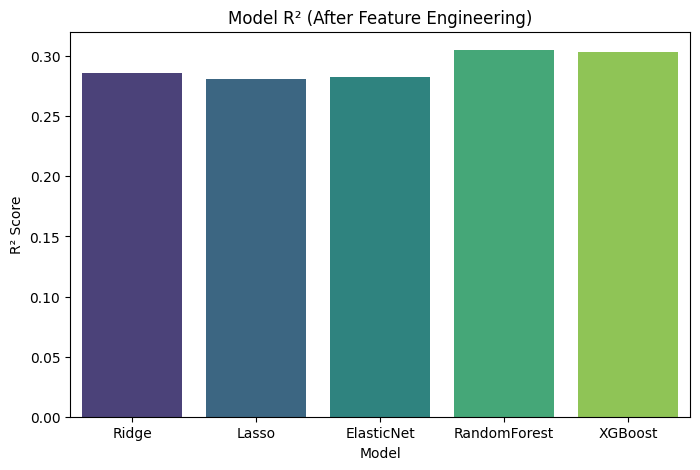

/tmp/ipython-input-1318783157.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='coolwarm')


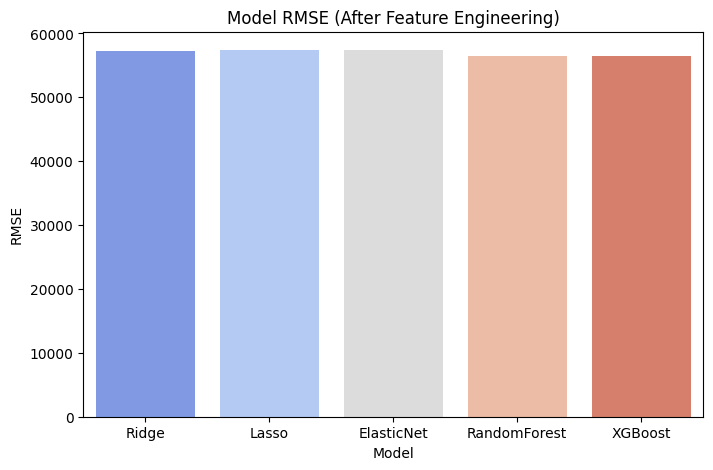


✅ Best performing model after feature engineering: RandomForest


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Target Encoder
!pip install category_encoders -q
import category_encoders as ce

df = pd.read_csv("DataScience_salaries_2025.csv")

print("Shape of dataset:", df.shape)
print(df.head())
print(df.info())

df.rename(columns={
    'work_year': 'year',
    'experience_level': 'seniority_level',
    'employment_type': 'status'
}, inplace=True)

# Convert remote ratio to work setting
df['work_setting'] = df['remote_ratio'].map({
    0: 'On-site',
    50: 'Hybrid',
    100: 'Remote'
})

# Clean string columns
for col in ['job_title', 'seniority_level', 'status',
            'employee_residence', 'company_location', 'company_size']:
    df[col] = df[col].astype(str).str.strip().str.title()

# Remove extreme outliers
df = df[df['salary_in_usd'] < 400000]
print("Data after cleaning:", df.shape)


df_2024 = df[df['year'] == 2024].copy()
print("Subset for 2024:", df_2024.shape)

# Combine important categorical relationships
df_2024['role_location'] = df_2024['job_title'] + "_" + df_2024['employee_residence']
df_2024['seniority_company'] = df_2024['seniority_level'] + "_" + df_2024['company_size']
df_2024['status_setting'] = df_2024['status'] + "_" + df_2024['work_setting']


X = df_2024[['seniority_level', 'status', 'job_title', 'company_size',
             'work_setting', 'employee_residence',
             'role_location', 'seniority_company', 'status_setting']]

y = df_2024['salary_in_usd']
y_log = np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "| Test samples:", X_test.shape[0])
encoder = ce.TargetEncoder(cols=X.columns)
X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc = encoder.transform(X_test)

models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=250, max_depth=12, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=10, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_enc, y_train)
    y_pred_log = model.predict(X_test_enc)
    y_pred = np.expm1(y_pred_log)   # Convert back to original salary scale
    y_true = np.expm1(y_test)

    results[name] = {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }


results_df = pd.DataFrame(results).T.round(3)
print("\n🔹 Model Results After Adding Interaction Features:")
print(results_df)

# Bar Plot – Model R²
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index(), x='index', y='R2', palette='viridis')
plt.title('Model R² (After Feature Engineering)')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.show()

# Bar Plot – RMSE
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='coolwarm')
plt.title('Model RMSE (After Feature Engineering)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()


best_model = results_df['R2'].idxmax()
print(f"\n✅ Best performing model after feature engineering: {best_model}")
